In [1]:
import itertools
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree._tree import TREE_LEAF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind
from tqdm import tqdm

In [2]:
# The Adult data source: https://archive.ics.uci.edu/ml/datasets/adult
adult_train = pd.read_csv("adult.data", sep=',\s+', engine='python')
adult_test = pd.read_csv("adult.test", sep=',\s+', engine='python')

In [3]:
adult_test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,outcome
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
# drop incomplete instances, rows that contain ? values
adult_test = adult_test[(adult_test != '?').all(1)]
adult_train = adult_train[(adult_train != '?').all(1)]

# drop fnlwgt column, which is uninformational and might cause overfitting
adult_test = adult_test.drop(columns=["fnlwgt"])
adult_train = adult_train.drop(columns=["fnlwgt"])

In [5]:
# separate labels
adult_test_y = adult_test['outcome']
adult_test_X = adult_test.loc[:, adult_test.columns != 'outcome']
adult_train_y = adult_train['outcome']
adult_train_X = adult_train.loc[:, adult_train.columns != 'outcome']

In [6]:
# transform labels to 0 and 1, above 50k is favorable outcome
adult_test_y = adult_test_y.map({'<=50K.': 0, '>50K.': 1})
adult_train_y = adult_train_y.map({'<=50K': 0, '>50K': 1})

In [7]:
# separate sensitive attributes from model data
adult_train_sex = adult_train_X["sex"]
adult_test_sex = adult_test_X["sex"]
adult_train_race = adult_train_X["race"]
adult_test_race = adult_test_X["race"]
adult_train_nc = adult_train_X["native-country"]
adult_test_nc = adult_test_X["native-country"]
adult_train_age = adult_train_X["age"]
adult_test_age = adult_test_X["age"]
adult_train_X = adult_train_X.drop(columns=["race", "sex", "native-country", "age"])
adult_test_X = adult_test_X.drop(columns=["race", "sex", "native-country", "age"])

In [8]:
# convert race data to binary white - non-white
race_map_dict = {"White": "White", "Black": "Non_White", "Asian-Pac-Islander": "Non_White", "Other": "Non_White", "Amer-Indian-Eskimo": "Non_White"}
adult_train_race = adult_train_race.map(race_map_dict)
adult_test_race = adult_test_race.map(race_map_dict)
adult_train_race.value_counts()

White        25933
Non_White     4229
Name: race, dtype: int64

In [9]:
# convert the two sensitive attributes into a dataframe and then into a series for the training set
adult_train_sexrace = pd.concat([adult_train_sex, adult_train_race], axis=1)
adult_train_sex_race = adult_train_sexrace[['sex', 'race']].agg('-'.join, axis=1)
adult_train_sex_race.value_counts()

Male-White          18038
Female-White         7895
Male-Non_White       2342
Female-Non_White     1887
dtype: int64

In [10]:
# convert the two sensitive attributes into a dataframe and then into a series for the test set
adult_test_sexrace = pd.concat([adult_test_sex, adult_test_race], axis=1)
adult_test_sex_race = adult_test_sexrace[['sex', 'race']].agg('-'.join, axis=1)
adult_test_sex_race.value_counts()

Male-White          8982
Female-White        3988
Male-Non_White      1165
Female-Non_White     925
dtype: int64

In [11]:
# convert both datasets to one-hot encoding
adult_train_cat_X = pd.get_dummies(adult_train_X)
adult_test_cat_X = pd.get_dummies(adult_test_X)

In [12]:
# reindex all datasets
adult_train_cat_X = adult_train_cat_X.reset_index(drop=True)
adult_train_y = adult_train_y.reset_index(drop=True)
adult_train_sex = adult_train_sex.reset_index(drop=True)
adult_train_race = adult_train_race.reset_index(drop=True)
adult_train_age = adult_train_age.reset_index(drop=True)
adult_train_nc = adult_train_nc.reset_index(drop=True)
adult_train_sex_race = adult_train_sex_race.reset_index(drop=True)

adult_test_cat_X = adult_test_cat_X.reset_index(drop=True)
adult_test_y = adult_test_y.reset_index(drop=True)
adult_test_sex = adult_test_sex.reset_index(drop=True)
adult_test_race = adult_test_race.reset_index(drop=True)
adult_test_age = adult_test_age.reset_index(drop=True)
adult_test_nc = adult_test_nc.reset_index(drop=True)
adult_test_sex_race = adult_test_sex_race.reset_index(drop=True)

## PAFER

In [13]:
def oracle(dataset, sens_dataset, rule, s_i, mechanism=None, epsilon=0.05, delta=0.001):
    """Returns some (differentially privatised) statistics on the sensitive attribute for the specified dataframe and rule
    
    Args:
        df: The DataFrame that the developers own, which does not contain sensitive attributes.
            Used to calculate total quantities in (root) nodes.
        sens_dataset: A Series that the developers do not own, which contains the sensitive attributes. 
            Combined sensitive attributes should be encoded as a Series, e.g. Black-Female
        rule: The rule, as a string, for which the to estimate the sensitive attribute.
        s_i: The sensitive attribute, its name comes from the ith element in the set S of sensitive attributes.
            s_i should be in sens_dataset and should thus be a string. 
        mechanism: The privacy mechanism used on the returned counts. Can be one of "gaussian", "laplacian", "exponential", None. 
        epsilon: The privacy budget. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1]. 
        
    Returns:
        The number of times s_i occurs in sens_dataset, privatised via the mechanism. 
        """
        
    # check epsilon and delta parameters
    if epsilon <= 0 or (mechanism == "gaussian" and (delta <= 0 or delta > 1 or epsilon > 1)):
        raise ValueError("The value of delta should be in (0,1] when using the gaussian mechanism")
    
    if not sens_dataset.isin([s_i]).any():
        raise KeyError("The requested sensitive attribute (s_i) is not in the sensitive dataframe (sens_dataset)")
        
    # the answer if no privacy mechanism is applied
    try:
        no_mechanism = sens_dataset.loc[dataset[pd.eval(rule, engine='python')].index].value_counts(sort=False)[s_i]
        
    except KeyError:
        no_mechanism = 0
    
    if mechanism == "laplacian":
        # this is a histogram query so the l1-sensitivity = 1 as per Dwork & Roth 
        sensitivity = 1
        return no_mechanism + np.random.laplace(loc=0, scale=sensitivity / epsilon)
    
    elif mechanism == "gaussian":
        # this is a histogram query so the l2-sensitivity = 2 as per Dwork & Roth
        sensitivity = 2
        return no_mechanism + np.random.normal(loc=0, scale=2 * sensitivity**2 * np.log(1.25 / delta) / epsilon**2)
    
    elif mechanism == "exponential":
        # this query can only change by 1 if an instance is omitted so l1-sensitivity = 1
        sensitivity = 1
        
        # np.arange is [start, stop) so + 1 for entire possible range
        possible_values = np.arange(0, sens_dataset.loc[dataset[pd.eval(rule, engine='python')].index].value_counts().to_numpy().sum() + 1)
        
        # the utility is higher when the value is closer to the actual value
        utility_scores = np.array([no_mechanism - abs(no_mechanism - value) for value in possible_values]) / 100
        probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in utility_scores]
        
        # normalize probabilties to sum to 1
        probabilities /= np.linalg.norm(probabilities, ord=1)
        return np.random.choice(possible_values, p=probabilities)

    # if no mechanism is given, return the unprivatised cocunt
    return no_mechanism


In [14]:
def statistical_parity(y_pred, sens_dataset):
    """Calculates Statistical Parity Ratio using the predictions and the actual sensitive feature values
    
    Args:
        y_pred: The predictions, should be of same size as sens_dataset.
        sens_dataset: The Series with the sensitive attributes.
        
    Returns:
        The true statistical parity ratio.
        """
    accept_rates = []
    
    for sens_attr in sorted(sens_dataset.unique()):
        accept_rates.append(np.sum((sens_dataset == sens_attr) & y_pred) / np.sum(sens_dataset == sens_attr))
        
    return min(accept_rates) / max(accept_rates)


def estimate_sp(pos_ruleset, dataset, sens_dataset, S, mechanism, epsilon, delta):
    """Returns the estimated Statistical Parity of a tree for a privacy mechanism
    
    Args:
        pos_ruleset: A list of rules that classify favorably in the tree. This is the representation of the
        (relevant parts of the) tree. 
        dataset: The DataFrame that the developers own that does not contain sensitive feature values.
        sens_dataset: The Series that contains the sensitive features, which the developers do not own.
        S: The set/list of sensitive attributes, should all be in the sens_dataset attribute.
        mechanism: The mechanism with which to privatise the queries. 
        epsilon: The privacy budget for the privacy mechanism. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1].
        
    Returns:
        The statistical parity ratio for the specified pos_ruleset. 
        """
    
    poscounts_per_si = np.zeros(len(S))
    
    # the variable name of the current dataset is inferred from the ruleset
    datasetname = str(pos_ruleset[0].split('[')[0])[1:]
    
    # the base rule is a rule that includes all individuals, i.e. the condition is a tautology
    # in this case we select all rows that have a value that is in the set of possible values of the first column
    base_rule = f"({datasetname}[{datasetname}.columns[0]].isin({datasetname}[{datasetname}.columns[0]].unique()))"
    
    # query the size of each sensitive attribute in the dataset
    total_per_si = [oracle(dataset, sens_dataset, base_rule, s_i, mechanism, 0.5 * epsilon, delta) for s_i in S]
        
    # replace each invalid value with balanced totals
    for i, tot in enumerate(total_per_si):
        if tot < 0 or tot > len(sens_dataset):
            total_per_si[i] = (1 / len(S)) * len(sens_dataset)
        
    total_per_si = np.array(total_per_si)
    
    for rule in pos_ruleset:
        # for each rule we find the distribution of sensitive attributes
        rule_counts = np.zeros(len(S))
        rule_total = len(sens_dataset[pd.eval(rule)])
        
        for i, s_i in enumerate(S):
            # because the queries are disjoint, epsilon remains equal across queries
            answer = round(oracle(dataset, sens_dataset, rule, s_i, mechanism, 0.5 * epsilon, delta))

            # if invalid answers from query: replace with balanced node value
            if answer < 0 or answer > len(sens_dataset):
                answer = (1 / len(S)) * rule_total

            rule_counts[i] += answer
        
        
        # the distribution for the current rule is added to the total
        poscounts_per_si += rule_counts
    
    # calculate and return sp
    accept_rates = poscounts_per_si / total_per_si
    return np.min(accept_rates) / np.max(accept_rates)


## Tree construction pipeline

In [15]:
tree = DecisionTreeClassifier(random_state=42)
parameter_grid={"criterion":["entropy", "gini"], 
                "max_features":["sqrt", None, "log2"], "ccp_alpha": [0.01, 0.05, 0.1],
               "min_impurity_decrease": [0.001, 0.005, 0.01, 0.025, 0.05], 
                "min_samples_leaf":[0.01, 0.02, 0.025, 0.05, 0.075, 0.1]}

tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=1)
tree_cv.fit(adult_train_cat_X, adult_train_y)
best_tree = tree_cv.best_estimator_

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


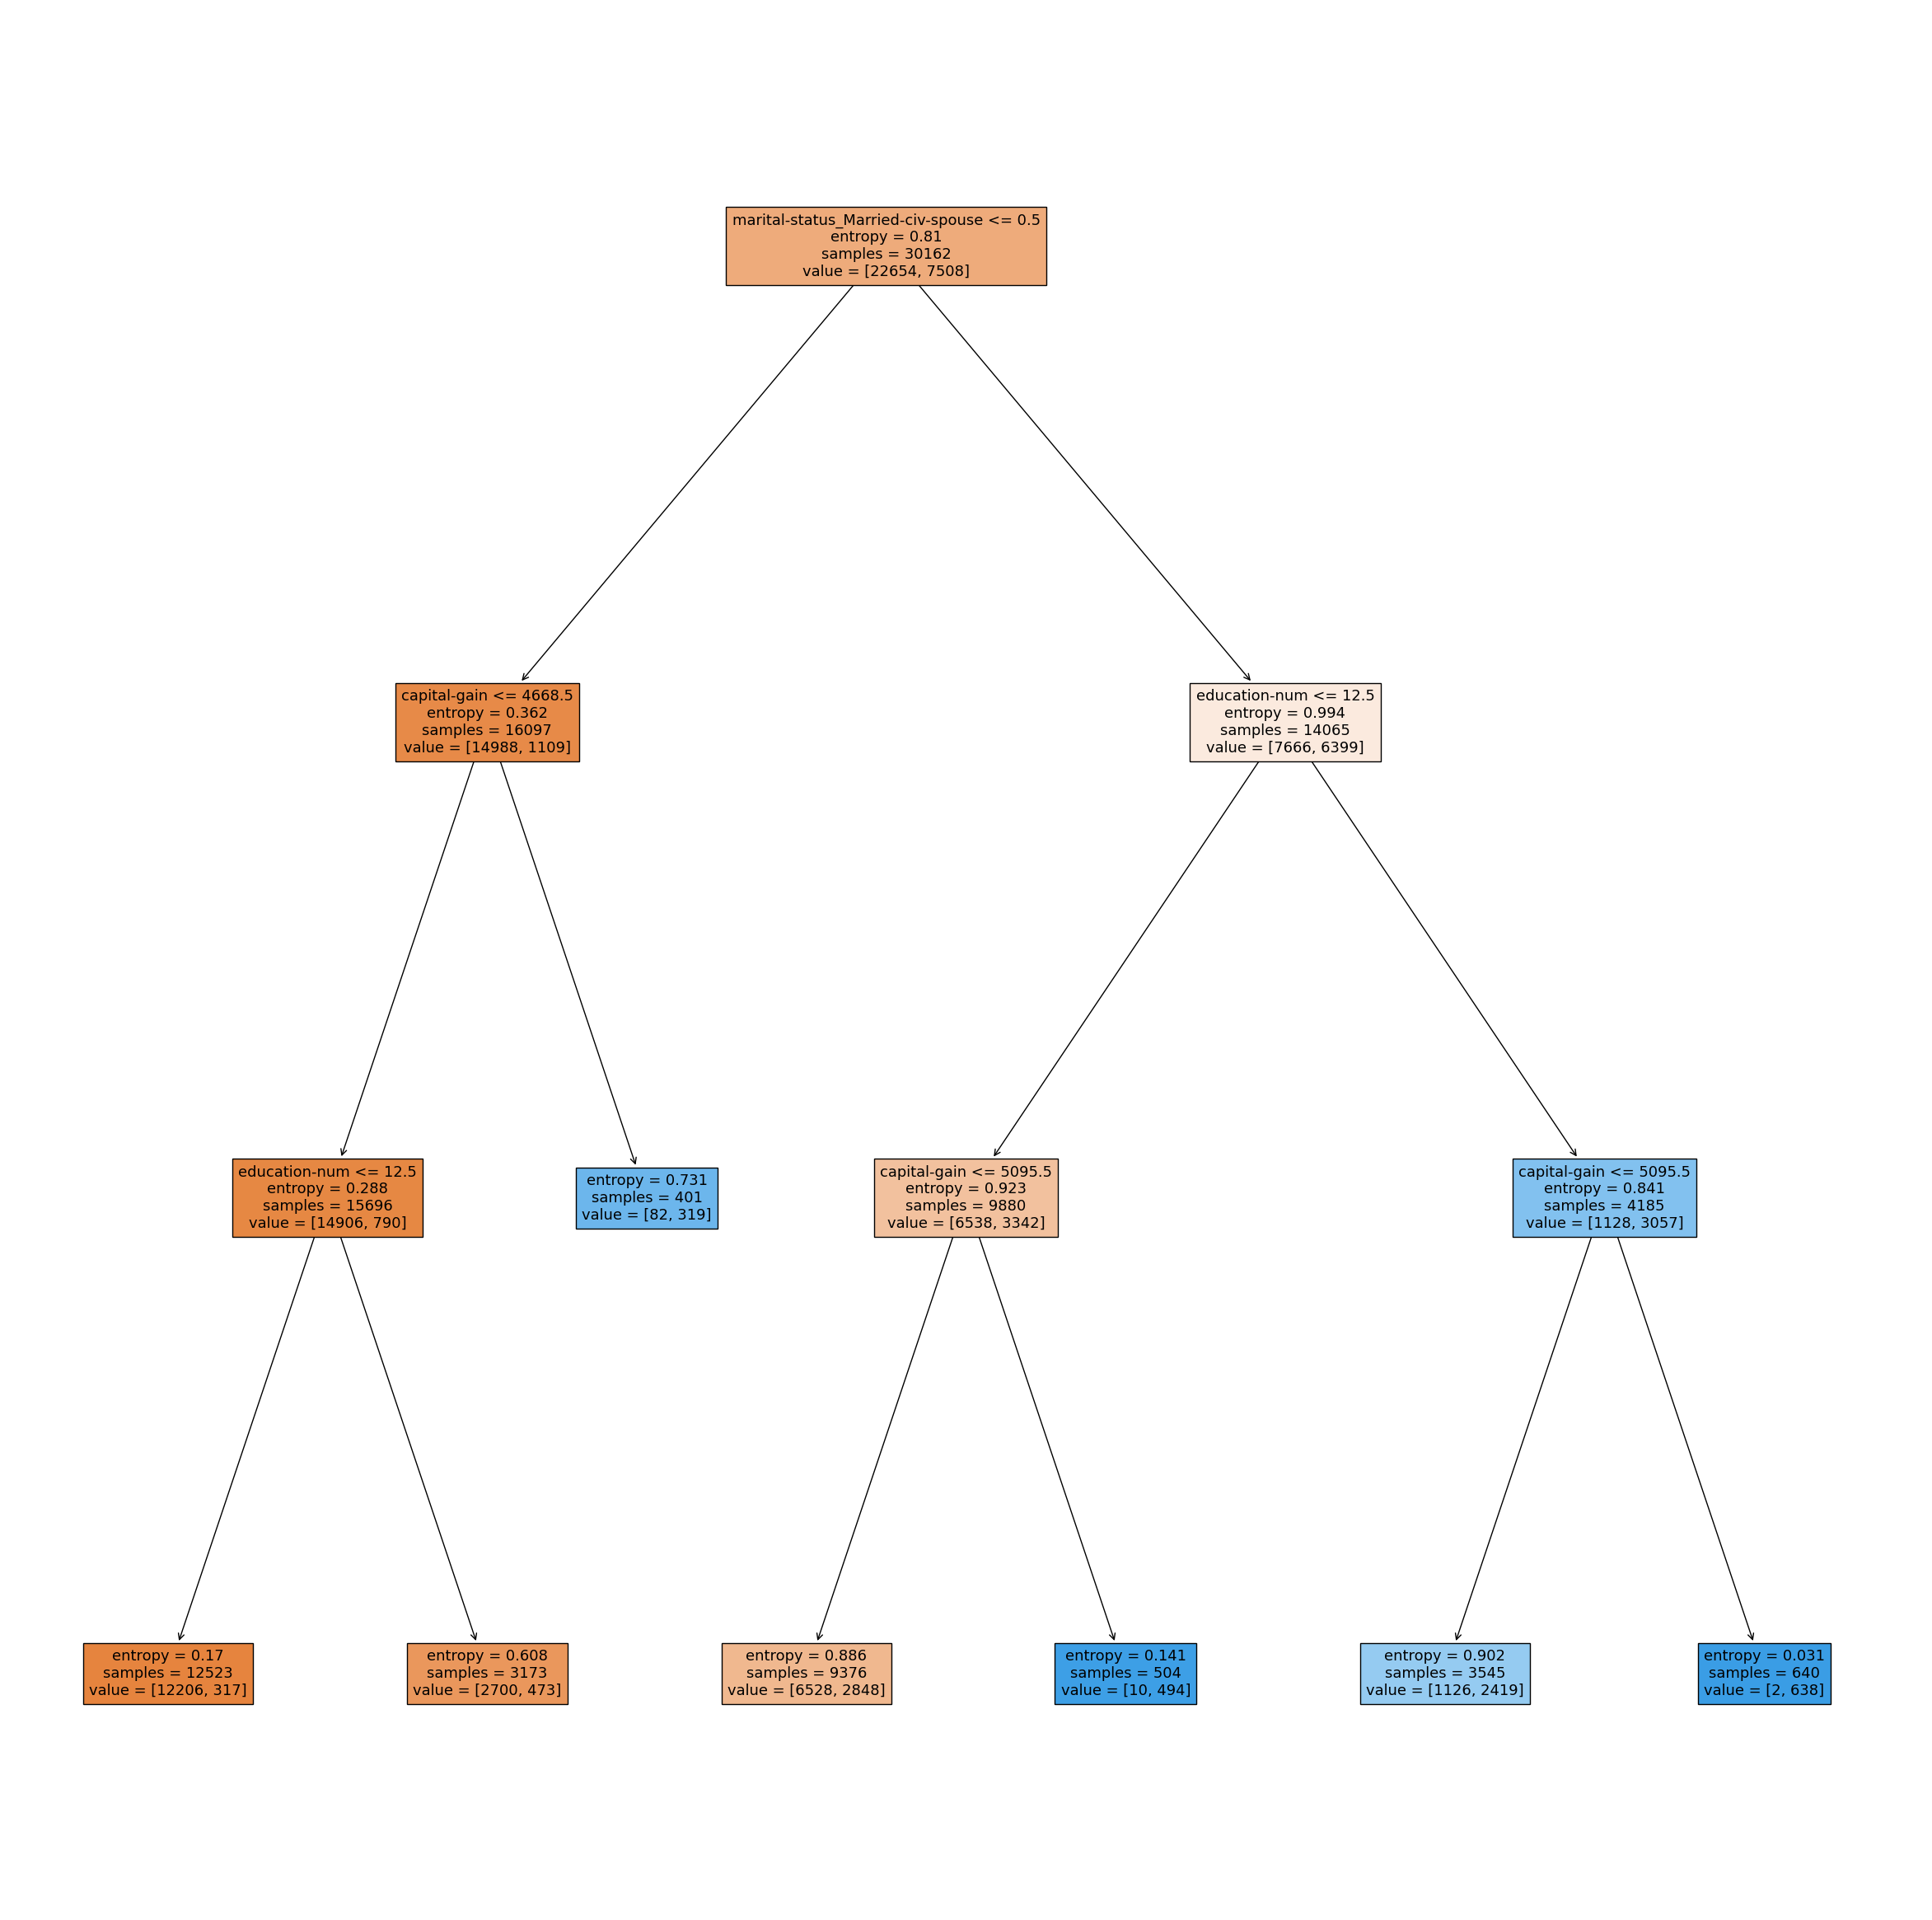

In [16]:
# column_names = [name for name in adult_train_cat_X.columns]
# print(export_text(best_tree, feature_names=column_names))
plt.figure(figsize=(30, 30))
plot_tree(best_tree, feature_names=adult_train_cat_X.columns, filled=True)
plt.show()

In [17]:
def find_paths(tree, dataset):
    def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (tree.tree_.children_left[node_numb] !=-1):
            left = find_path(tree.tree_.children_left[node_numb], path, x)
        if (tree.tree_.children_right[node_numb] !=-1):
            right = find_path(tree.tree_.children_right[node_numb], path, x)
        if left or right:
            return True
        path.remove(node_numb)
        return False

    # Leaves
    leave_id = tree.apply(dataset)

    paths = {}
    for leaf in np.unique(leave_id):
        path_leaf = []
        find_path(0, path_leaf, leaf)
        paths[leaf] = np.unique(np.sort(path_leaf))
        
    return paths
        
def avg_feature_thresholds(tree, dataset, max_depth=7):
    paths = find_paths(tree, dataset)
    feature_clause_thresholds = np.zeros((dataset.shape[1], max_depth))
    feature_clause_counts = np.zeros((dataset.shape[1], max_depth))
    seen_nodes = set()

    for path in paths.values():
        # last node is a leaf node that contains no feature
        for depth, node in enumerate(path[:-1]):
            if node not in seen_nodes:
                feature_clause_thresholds[tree.tree_.feature[node], depth] += tree.tree_.threshold[node]
                feature_clause_counts[tree.tree_.feature[node], depth] += 1
                seen_nodes.add(node)
    
    return feature_clause_thresholds, feature_clause_counts


In [18]:
def find_best_forest(n_trees=50, max_depth=7):
    # Train a random forest classifier with n_estimators trees
    rf = RandomForestClassifier(random_state=42, n_estimators=n_trees)
    parameter_grid={"criterion":["entropy", "gini"], "max_depth":np.arange(3,7+1), 
                    "max_features":["sqrt", None], 
                    "min_samples_leaf":[0.01, 0.025, 0.05, 0.075, 0.1], 
                    "ccp_alpha": np.logspace(-5, 0, 5)[:-1]}

    rf_cv = GridSearchCV(rf, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=3, cv=3, verbose=1)
    rf_cv.fit(adult_train_cat_X.values, adult_train_y)
    return rf_cv.best_estimator_
    
def round_half(num):
    return round(num * 2) / 2.0


In [19]:
# transform the most useful numerical features to categorical features using binning

n_trees = 5
max_depth = 7
numeric_feature_idxs = [0,1,2,3]
best_rf = find_best_forest(n_trees=n_trees, max_depth=max_depth)

# calculate average over all trees
feature_clause_thresholds = np.zeros((adult_train_cat_X.shape[1], max_depth))
feature_clause_counts = np.zeros((adult_train_cat_X.shape[1], max_depth)) 
for tree in best_rf.estimators_:
    t, c = avg_feature_thresholds(tree, adult_train_cat_X, max_depth=max_depth)
    feature_clause_thresholds += t
    feature_clause_counts += c 

# categorize the numeric variables
useful_feature_idxs = []
for numeric_feature_idx in numeric_feature_idxs:
    thresholds, counts = feature_clause_thresholds[numeric_feature_idx], feature_clause_counts[numeric_feature_idx]

    if counts.any():
        # ignore division by zero and zero / zero warnings
        with np.errstate(divide='ignore', invalid='ignore'):
            avgs = (thresholds/counts)

        bins = [-np.inf] + sorted(np.unique([round(avg) for avg in avgs[~np.isnan(avgs)]])) + [np.inf] 
        names = [f'<{bins[1]}'] + [f'{binn}-{bins[i+2]}' for i, binn in enumerate(bins[1:-2])] + [f'{bins[-2]}+']

        adult_train_cat_X.iloc[:, numeric_feature_idx] = pd.cut(adult_train_cat_X.iloc[:, numeric_feature_idx], bins, labels=names)
        adult_test_cat_X.iloc[:, numeric_feature_idx] = pd.cut(adult_test_cat_X.iloc[:, numeric_feature_idx], bins, labels=names)
        useful_feature_idxs.append(numeric_feature_idx)

adult_train_cat_X = pd.get_dummies(data=adult_train_cat_X, columns=adult_train_cat_X.columns[useful_feature_idxs])
adult_test_cat_X = pd.get_dummies(data=adult_test_cat_X, columns=adult_test_cat_X.columns[useful_feature_idxs])


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


/Users/florianvandersteen/miniconda3/envs/experiments/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/florianvandersteen/miniconda3/envs/experiments/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/florianvandersteen/miniconda3/envs/experiments/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/florianvandersteen/miniconda3/envs/experiments/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/florianvandersteen/miniconda3/envs/experiments/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, bu

In [20]:
adult_test_cat_X

,capital-loss,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,...,education-num_9-10,education-num_10-12,education-num_12+,capital-gain_<3549,capital-gain_3549-4921,capital-gain_4921+,hours-per-week_<38,hours-per-week_38-40,hours-per-week_40-42,hours-per-week_42+
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
15056,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
15057,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
15058,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


In [21]:
def find_best_tree(dataset, dataset_labels, minleaf=0.01):
    # no random_state because we want a different tree each run
    tree = DecisionTreeClassifier()

    parameter_grid = {"criterion":["entropy", "gini"],
                      "max_features":["sqrt", "log2"], 
                      "min_samples_leaf":[minleaf]}
    
    tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=0)
    tree_cv.fit(dataset, dataset_labels)
    best_tree = tree_cv.best_estimator_
    return best_tree


In [22]:
# taken from: https://stackoverflow.com/a/51398390
def is_leaf(inner_tree, index):
    # check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # prune children if both children are leaves now and make the same decision
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF

def prune_duplicate_leaves(mdl):
    # Remove leaves if all siblings make the same decision
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)
    
# pruning happens in-place
prune_duplicate_leaves(best_tree)

In [23]:
def positive_rules (tree, rules):
    """From the extracted rules, return those that have a favorable classification

    Arg:
        tree: The tree classification object from which the rules are extracted. 
        rules: Dict of which the values are rule strings.

    Returns:
        A list of all the rules that classify favorably"""

    # only those rules are added for which the majority of individuals in the node is at index 1, i.e. max
    # index 1 corresponds to class 1
    return [rule for node_id, rule in rules.items() if np.argmax(tree.tree_.value[node_id][0])]


In [24]:
# taken from: https://stackoverflow.com/a/56427596

def extract_pos_rules(tree, dataset, datasetname):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False


    def get_rule(datasetname, path, column_names):
        mask = '('
        for index, node in enumerate(path):
            # check if we are not in the leaf
            if index!=len(path)-1:
                # under or over the threshold?
                if (children_left[node] == path[index+1]):
                    mask += f"{datasetname}['{column_names[feature[node]]}']<= {threshold[node]}\t "
                else:
                    mask += f"{datasetname}['{column_names[feature[node]]}']> {threshold[node]} \t "

        # insert the & at the right places
        mask = mask.replace("\t", "&", mask.count("\t") - 1)
        mask = mask.replace("\t", "")
        mask += ")"
        return mask
    
    # Leaves
    leave_id = tree.apply(dataset)

    paths = {}
    for leaf in np.unique(leave_id):
        path_leaf = []
        find_path(0, path_leaf, leaf)
        paths[leaf] = np.unique(np.sort(path_leaf))

    rules = {}
    for key in paths:
        rules[key] = get_rule(datasetname, paths[key], [name for name in dataset.columns])
        
    return positive_rules(tree, rules)
        

## PAFER Experiments

In [25]:
def bootstrap(dataset, dataset_labels, sens_dataset):
    indices = np.random.choice(dataset.index, size=len(dataset.index))
    
    return dataset.iloc[indices], dataset_labels.iloc[indices], sens_dataset.iloc[indices]

# dataset, labels, sens_dataset = bootstrap(adult_test_cat_X, adult_test_y, adult_test_sex)

In [28]:
def experiment(trainset, sens_trainset, trainsetname, trainset_labels, testset, sens_testset, testsetname, 
               testset_labels, epsilon=0.1, minleaf=0.01, runs=5, combined=False):
    tree_sps = np.zeros(runs)
    estimated_sps = np.zeros(runs)
    for i in range(runs):
        ruleset = []
        while ruleset == [] or ruleset == ['()']:
            # sample with replacement
            dataset, dataset_labels, sens_dataset = bootstrap(trainset, trainset_labels, sens_trainset)
            
            # build tree 
            best_tree = find_best_tree(trainset, trainset_labels, minleaf)
        
            # extract positive rules
            prune_duplicate_leaves(best_tree)
            ruleset = extract_pos_rules(best_tree, trainset, testsetname)
        
        if combined:
            ruleset = [" | ".join(rule for rule in ruleset)]

        # calculate true sp
        tree_sps[i] = statistical_parity(best_tree.predict(testset), sens_testset)
        
        # apply PAFER
        estimated_sps[i] = estimate_sp(ruleset, testset, sens_testset, sorted(sens_testset.unique()), mechanism='laplacian', epsilon=epsilon)
        
    return tree_sps, estimated_sps

In [ ]:
minleafs = np.linspace(0.2, 0.001, 80)
print(minleafs)
runs = 50
epsilon = 0.1

# storage for results
avg_tree_sps = []
avg_estimated_sps = []
avg_errs = []
uncerts = []
eighty_percents = []
for minleaf in tqdm(minleafs):
    tree_sps, estimated_sps = experiment(adult_train_cat_X, adult_train_sex, "adult_train_cat_X", adult_train_y, 
                                         adult_test_cat_X, adult_test_sex, "adult_test_cat_X", adult_test_y,
                                         epsilon=epsilon, minleaf=minleaf, runs=runs)
    
    avg_tree_sps.append(np.mean(tree_sps))
    avg_estimated_sps.append(np.mean(estimated_sps))
    avg_errs.append(np.mean(np.abs(tree_sps - estimated_sps)))
    uncerts.append(np.std(np.abs(tree_sps - estimated_sps)) / np.sqrt(len(tree_sps)))
    eighty_percents.append((tree_sps >= 0.8))
    

In [230]:
avg_tree_sps = np.array(avg_tree_sps)
avg_estimated_sps = np.array(avg_estimated_sps)
avg_errs = np.array(avg_errs)
uncerts = np.array(uncerts)
eighty_percents = np.array(eighty_percents)

for arr, name in zip([avg_tree_sps, avg_estimated_sps, avg_errs, uncerts, eighty_percents], ["tree_sps", "estimated_sps", "errs", "uncerts", "eighty_percents"]):
    with open(f"adult-sex-{name}", "wb") as f:
        np.save(f, arr)

In [ ]:
minleafs = np.linspace(0.2, 0.001, 40)
print(minleafs)
runs = 50
epsilon = 0.1

# storage for results
avg_tree_sps = []
avg_estimated_sps = []
avg_errs = []
uncerts = []
eighty_percents = []
for minleaf in tqdm(minleafs):
    tree_sps, estimated_sps = experiment(adult_train_cat_X, adult_train_race, "adult_train_cat_X", adult_train_y, 
                                         adult_test_cat_X, adult_test_race, "adult_test_cat_X", adult_test_y,
                                         epsilon=epsilon, minleaf=minleaf, runs=runs)
    
    avg_tree_sps.append(np.mean(tree_sps))
    avg_estimated_sps.append(np.mean(estimated_sps))
    avg_errs.append(np.mean(np.abs(tree_sps - estimated_sps)))
    uncerts.append(np.std(np.abs(tree_sps - estimated_sps)) / np.sqrt(len(tree_sps)))
    eighty_percents.append((tree_sps >= 0.8))
    

In [187]:
avg_tree_sps = np.array(avg_tree_sps)
avg_estimated_sps = np.array(avg_estimated_sps)
avg_errs = np.array(avg_errs)
uncerts = np.array(uncerts)
eighty_percents = np.array(eighty_percents)

for arr, name in zip([avg_tree_sps, avg_estimated_sps, avg_errs, uncerts, eighty_percents], ["tree_sps", "estimated_sps", "errs", "uncerts", "eighty_percents"]):
    with open(f"adult-race-{name}", "wb") as f:
        np.save(f, arr)

In [ ]:
minleafs = np.linspace(0.2, 0.001, 40)
print(minleafs)
runs = 50
epsilon = 0.1

# storage for results
avg_tree_sps = []
avg_estimated_sps = []
avg_errs = []
uncerts = []
eighty_percents = []
for minleaf in tqdm(minleafs):
    tree_sps, estimated_sps = experiment(adult_train_cat_X, adult_train_sex_race, "adult_train_cat_X", adult_train_y, 
                                         adult_test_cat_X, adult_test_sex_race, "adult_test_cat_X", adult_test_y,
                                         epsilon=epsilon, minleaf=minleaf, runs=runs)
    
    avg_tree_sps.append(np.mean(tree_sps))
    avg_estimated_sps.append(np.mean(estimated_sps))
    avg_errs.append(np.mean(np.abs(tree_sps - estimated_sps)))
    uncerts.append(np.std(np.abs(tree_sps - estimated_sps)) / np.sqrt(len(tree_sps)))
    eighty_percents.append((tree_sps >= 0.8))
    

In [238]:
avg_tree_sps = np.array(avg_tree_sps)
avg_estimated_sps = np.array(avg_estimated_sps)
avg_errs = np.array(avg_errs)
uncerts = np.array(uncerts)
eighty_percents = np.array(eighty_percents)

for arr, name in zip([avg_tree_sps, avg_estimated_sps, avg_errs, uncerts, eighty_percents], ["tree_sps", "estimated_sps", "errs", "uncerts", "eighty_percents"]):
    with open(f"adult-sex_race-{name}", "wb") as f:
        np.save(f, arr)